In [3]:
import csv
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import time
from os import walk
import itertools
from itertools import chain
%matplotlib inline
from operator import add

import statistics
from statistics import mean
import math
from pprint import pprint
from nltk import *

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [4]:
# read all .csv files
# --- 0.02096700668334961 seconds ---
games_cols = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr', 'homeDisplayName', 'visitorDisplayName']
games = pd.read_csv('../gits/Big-Data-Bowl/Data/games.csv', usecols=games_cols)

players_cols = ['nflId', 'FirstName', 'LastName', 'PositionAbbr']
players = pd.read_csv('../gits/Big-Data-Bowl/Data/players.csv', usecols=players_cols)

plays_cols = ['gameId', 'playId', 'quarter', 'yardsToGo', 'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation', 'personnel.offense']
plays = pd.read_csv('../gits/Big-Data-Bowl/Data/plays.csv', usecols=plays_cols)

In [5]:
# read each game file
# --- 28.45746684074402 seconds ---
gameX_cols = ['x', 'y', 'event','nflId', 'displayName', 'team', 'gameId', 'playId']
gameX_files = []
# create 1 giant list of all game files
for (dirpath, dirnames, filenames) in walk('../gits/Big-Data-Bowl/Data_Tracking/'):
    gameX_files.extend(filenames)
gameX_files = sorted(gameX_files)

game = {}
# label it game[i], for example game[0] is a dataframe of the first game
for i, each in enumerate(gameX_files):
    game[i] = pd.read_csv('../gits/Big-Data-Bowl/Data_Tracking/'+str(each), usecols=gameX_cols)

# GAMES

In [6]:
games.head()

,gameId,homeTeamAbbr,visitorTeamAbbr,homeDisplayName,visitorDisplayName
0,2017091004,DET,ARI,Detroit Lions,Arizona Cardinals
1,2017090700,NE,KC,New England Patriots,Kansas City Chiefs
2,2017091003,CLE,PIT,Cleveland Browns,Pittsburgh Steelers
3,2017091002,CIN,BAL,Cincinnati Bengals,Baltimore Ravens
4,2017091000,BUF,NYJ,Buffalo Bills,New York Jets


# PLAYERS

In [7]:
players.head()

,nflId,FirstName,LastName,PositionAbbr
0,79860,John,Stafford,QB
1,71465,Andre,Smith,T
2,80427,Darrius,Heyward-Bey,WR
3,71269,Michael,Crabtree,WR
4,71423,Brian,Orakpo,OLB


In [8]:
# create a dictionary for all positions and their respective players
position_counts = {}
positions = []
for each in players['PositionAbbr']:
    positions.append(each)
    for each in set(positions):
        count = positions.count(each)
        position_counts[each] = count
# pprint(position_counts)

In [9]:
# --- 0.3077890872955322 seconds ---
# creates a dictionary of 'player_name(string)' : nflId(number)
def player_id_by_pos(string):
    dictionary = {}
    for each in range(0,len(players)):
        if players.iloc[each,3] == string:
            dictionary[players.iloc[each,1] + ' ' + players.iloc[each,2]] = players.iloc[each,0]
    return dictionary

C_dict = player_id_by_pos('C')      # Center               @ 55,
CB_dict = player_id_by_pos('CB')    # Corner Back          @ 180,
DB_dict = player_id_by_pos('DB')    # Defense Back         @ 3,
DE_dict = player_id_by_pos('DE')    # Defense End          @ 130,
DT_dict = player_id_by_pos('DT')    # Defense Tackle       @ 107,
FB_dict = player_id_by_pos('FB')    # Full Back            @ 25,
FS_dict = player_id_by_pos('FS')    # Free Safety          @ 79,
G_dict = player_id_by_pos('G')      # Guard                @ 106,
ILB_dict = player_id_by_pos('ILB')  # Inside Linebacker    @ 64,
K_dict = player_id_by_pos('K')      # Kicker               @ 36,
LB_dict = player_id_by_pos('LB')    # Line Backer          @ 4,
LS_dict = player_id_by_pos('LS')    # Long Snapper         @ 34,
MLB_dict = player_id_by_pos('MLB')  # Middle Linebacker    @ 38,
NT_dict = player_id_by_pos('NT')    # Nose Tackle          @ 27,
OLB_dict = player_id_by_pos('OLB')  # Outside Linebacker   @ 139,
P_dict = player_id_by_pos('P')      # Punter               @ 33,
QB_dict = player_id_by_pos('QB')    # Quarter Back         @ 50,
RB_dict = player_id_by_pos('RB')    # Running Back         @ 120,
SS_dict = player_id_by_pos('SS')    # Strong Safety        @ 73,
T_dict = player_id_by_pos('T')      # Tackle               @ 107,
TE_dict = player_id_by_pos('TE')    # Tight End            @ 109,
WR_dict = player_id_by_pos('WR')    # Wide Receiver        @ 194

# PLAYS

In [10]:
plays.head()

,gameId,playId,quarter,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense
0,2017091004,37,1,0,DET,DET,35.0,NaN,NaN
1,2017091004,73,1,10,ARI,ARI,23.0,SHOTGUN,"1 RB, 1 TE, 3 WR"
2,2017091004,97,1,6,ARI,ARI,27.0,SINGLEBACK,"1 RB, 1 TE, 3 WR"
3,2017091004,118,1,4,ARI,ARI,29.0,SHOTGUN,"1 RB, 0 TE, 4 WR"
4,2017091004,153,1,10,ARI,ARI,44.0,SHOTGUN,"1 RB, 2 TE, 2 WR"


# GAME_X

In [11]:
game[0].head()

,x,y,event,nflId,displayName,team,gameId,playId
0,41.56,16.54,NaN,2495340.0,Anthony Sherman,away,2017090700,44
1,41.95,16.62,NaN,2495340.0,Anthony Sherman,away,2017090700,44
2,42.40,16.73,NaN,2495340.0,Anthony Sherman,away,2017090700,44
3,42.85,16.82,NaN,2495340.0,Anthony Sherman,away,2017090700,44
4,43.36,16.92,kickoff,2495340.0,Anthony Sherman,away,2017090700,44


In [12]:
list_of_forms = []
for each in set(plays['offenseFormation'].values):
    if type(each) == str:
        list_of_forms.append(each)
clean_plays = plays.loc[plays['offenseFormation'].isin(list_of_forms)]

In [13]:
# --- 3.602159261703491 seconds ---
types_of_snaps = ['kickoff', 'ball_snap', 'snap_direct']
all_snaps = game[0].loc[game[0]['event'].isin(types_of_snaps)]
for i in range(1,len(games)):
    all_snaps = all_snaps.append(game[i].loc[game[i]['event'].isin(types_of_snaps)], ignore_index=True)

In [14]:
all_snaps.head(11)

,x,y,event,nflId,displayName,team,gameId,playId
0,43.36,16.92,kickoff,2495340.0,Anthony Sherman,away,2017090700,44
1,43.84,37.50,kickoff,2507948.0,Frank Zombo,away,2017090700,44
2,44.73,19.94,kickoff,2541187.0,Demetrius Harris,away,2017090700,44
3,44.16,13.78,kickoff,2543563.0,Kevin Pierre-Louis,away,2017090700,44
4,42.89,48.28,kickoff,2543638.0,De'Anthony Thomas,away,2017090700,44
5,43.09,6.67,kickoff,2549981.0,Kenneth Acker,away,2017090700,44
6,44.28,31.39,kickoff,2550257.0,Daniel Sorensen,away,2017090700,44
7,44.97,26.96,kickoff,2550636.0,Cairo Santos,away,2017090700,44
8,44.11,45.64,kickoff,2555173.0,Eric Murray,away,2017090700,44
9,44.18,41.41,kickoff,2556775.0,Terrance Smith,away,2017090700,44


In [15]:
# --- 0.0003311634063720703 seconds ---
# returns a list of all game IDs
def ret_list_of_games():
    list_of_games = []
    game_list = games.gameId.unique()
    for each in game_list:
        list_of_games.append(each)
    return sorted(list_of_games)

In [16]:
# --- 0.0011780261993408203 seconds ---
# returns a list of all plays given a game ID
def ret_list_of_plays_of_game(game_num):
#     game_file = game[game_num]
#     if len(game_file.gameId.unique()) == 1:
#         game_id = game_file.gameId.unique().item()
#     else:
#         game_id = int(statistics.median(game_file['gameId']))
    list_of_plays = []
    play_list = clean_plays.loc[clean_plays['gameId'] == game_num].playId.unique()
    for each in play_list:
        list_of_plays.append(each)
    return sorted(list_of_plays)

In [17]:
# print(ret_list_of_plays_of_game(2017090700))

In [18]:
# --- 0.03001999855041504 seconds ---
# returns a list of all the df indeces for defending players given a game ID and play ID
def list_of_defending_players(game_num, play_num):
    remove_non_off = []
    # if home team in games.csv == possession team in clean_plays.csv
    if games.loc[games['gameId'] == game_num]['homeTeamAbbr'].item() == clean_plays.loc[clean_plays['gameId'] == game_num].loc[clean_plays['playId'] == play_num]['possessionTeam'].item():
        # for each row in all_snaps where the gameID and playID match, append defending (away) players
        for each in all_snaps.loc[all_snaps['gameId'] == game_num].loc[all_snaps['playId'] == play_num].loc[all_snaps['team'] == 'away'].index.values:
            remove_non_off.append(each)
    # if away team in games.csv == possession team in clean_plays.csv
    elif games.loc[games['gameId'] == game_num]['visitorTeamAbbr'].item() == clean_plays.loc[clean_plays['gameId'] == game_num].loc[clean_plays['playId'] == play_num]['possessionTeam'].item():
        # for each row in all_snaps where the gameID and playID match, append defending (home) players
        for each in all_snaps.loc[all_snaps['gameId'] == game_num].loc[all_snaps['playId'] == play_num].loc[all_snaps['team'] == 'home'].index.values:
            remove_non_off.append(each)
    return remove_non_off

# list_of_defending_players(2017090700, 68)

In [19]:
# --- 265.12225008010864 seconds ---
# returns all df indeces for defending players
def list_of_indeces_with_defending_players():
    list_of_play_removals = []
    list_of_games = ret_list_of_games()
    # for each game
    for each_game in list_of_games:
        list_of_plays_of_game = ret_list_of_plays_of_game(each_game)
        # and for each play in each game
        for each_play in list_of_plays_of_game:
            # add to the list the indeces of defending players
            for each_index in list_of_defending_players(each_game, each_play):
                list_of_play_removals.append(each_index)
    return list_of_play_removals

In [20]:
# the list of indeces with defending players from all_snaps
# WARNING: TAKES 265 SECONDS TO LOAD
rem_these_ind = list_of_indeces_with_defending_players()

In [21]:
# all offense-only rows in dataframe all_snaps
all_off_snaps = all_snaps.drop(rem_these_ind)
all_off_snaps.head()

,x,y,event,nflId,displayName,team,gameId,playId
0,43.36,16.92,kickoff,2495340.0,Anthony Sherman,away,2017090700,44
1,43.84,37.50,kickoff,2507948.0,Frank Zombo,away,2017090700,44
2,44.73,19.94,kickoff,2541187.0,Demetrius Harris,away,2017090700,44
3,44.16,13.78,kickoff,2543563.0,Kevin Pierre-Louis,away,2017090700,44
4,42.89,48.28,kickoff,2543638.0,De'Anthony Thomas,away,2017090700,44


In [22]:
# 2D array of [xi(relative),yi] positions
# changed to 1D
def xi_yi(game_num, play_num):
    df_offs = all_off_snaps.loc[all_off_snaps['gameId'] == game_num].loc[all_off_snaps['playId'] == play_num]
    try:
        the_mean = np.mean(df_offs['x'].values)
        the_median = statistics.median(df_offs['x'].values)
        inp_list = []
        inp_list2 = []
        if the_median > the_mean:
            for index,row in df_offs.iterrows():
                inp_list.append(round(max(df_offs['x']) - row['x'], 2))
                inp_list.append(row['y'])
        elif the_mean > the_median:
            for index,row in df_offs.iterrows():
                inp_list.append(round(row['x'] - min(df_offs['x']), 2))
                inp_list.append(row['y'])

        inp_list2 = np.reshape(inp_list, (-1, 2))

        the_form = clean_plays.loc[clean_plays['gameId'] == game_num].loc[clean_plays['playId'] == play_num]['offenseFormation'].item()
        output = the_form
        if type(output) != str:
            return None
        
        # note that inp_list is a list: [x1,y1,x2,y2...]
        if len(inp_list) != 22:
            return None
        return inp_list, output
        # note that inp_list2 is an array: [[x1,y1],[x2,y2]...]
#         if len(inp_list2) != 11:
#             return None
#         return inp_list2, output
    except:
        pass

In [23]:
# --- 54.21045970916748 seconds ---
# returns list of all relative xi coordinates and yi
def list_of_xi_yi():
    list_of_games = ret_list_of_games()
    list_of_inp_out = []
    for each_game in list_of_games:
        list_of_plays_of_game = ret_list_of_plays_of_game(each_game)
        for each_play in list_of_plays_of_game:
            each_coord = xi_yi(each_game, each_play)
            list_of_inp_out.append(each_coord)
    return list_of_inp_out

In [26]:
# might get a runtime warning, but it works
xiyi_list = list_of_xi_yi()

In [27]:
# new df consisting of x-y pos & form
def create_new_df():
    new_df = pd.DataFrame(columns=['x-y', 'o_form'])
    for i in range(len(xiyi_list)):
        if type(xiyi_list[i]) == tuple:
            # use this line for inp_list1
            new_df.loc[i] = [xiyi_list[0:len(xiyi_list)][i][0]] + [xiyi_list[0:len(xiyi_list)][i][1]]
            # use this line for inp_list2
#             new_df.loc[i] = [xiyi_list[0:len(xiyi_list)][i][0].tolist()] + [xiyi_list[0:len(xiyi_list)][i][1]]
    return new_df

In [28]:
# --- 17.830195903778076 seconds ---
new_df = create_new_df()

In [29]:
new_df.head()

,x-y,o_form
0,"[0.23, 34.79, 0.51, 32.84, 0.32, 26.61, 0.73, ...",SINGLEBACK
1,"[1.36, 19.45, 0.69, 34.63, 0.62, 32.82, 0.38, ...",SINGLEBACK
2,"[1.77, 17.37, 0.42, 34.67, 0.74, 32.92, 0.48, ...",SHOTGUN
3,"[2.59, 20.75, 0.45, 32.66, 0.71, 31.04, 0.48, ...",SHOTGUN
4,"[1.15, 33.03, 1.26, 37.15, 0.7, 29.76, 0.61, 2...",EMPTY


In [30]:
X = []
for index,each in new_df[['x-y']].iterrows():
    X.append(each[0])
y = []
for index,each in new_df[['o_form']].iterrows():
    y.append(each[0])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.89


In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.88
Accuracy of K-NN classifier on test set: 0.82


In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.66
Accuracy of GNB classifier on test set: 0.66


In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.59
Accuracy of LDA classifier on test set: 0.59


In [36]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Logistic Regression Acc on training set: {:.2f}'
      .format(logreg.score(X_train, y_train)))
print('Logistic Regression Acc on test set: {:.2f}'
      .format(logreg.score(X_test, y_test)))

Logistic Regression Acc on training set: 0.57
Logistic Regression Acc on test set: 0.57


In [37]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.51
Accuracy of SVM classifier on test set: 0.51


In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = clf.predict(X_test)
print('=====================================')
print(confusion_matrix(y_test, pred))
print('====================================================')
print(classification_report(y_test, pred))
print('====================================================')

[[ 171    2    0    0   46    4    0]
 [   1  249   17    6    8   42    1]
 [   0    7   10    0    1    7    0]
 [   2    9    1   17    3    3    0]
 [  44   17    4    8 1360   20    1]
 [   8   25   11    1   13  701    1]
 [   2    1    0    0    4    2    0]]
             precision    recall  f1-score   support

      EMPTY       0.75      0.77      0.76       223
     I_FORM       0.80      0.77      0.79       324
      JUMBO       0.23      0.40      0.29        25
     PISTOL       0.53      0.49      0.51        35
    SHOTGUN       0.95      0.94      0.94      1454
 SINGLEBACK       0.90      0.92      0.91       760
    WILDCAT       0.00      0.00      0.00         9

avg / total       0.89      0.89      0.89      2830



In [39]:
def map2_play(game_file, play_sequence):
    
    # from games.csv
    game_file = game[game_file]
    game_id = int(statistics.median(game_file['gameId']))
    game_df_in_all_games = games.loc[games['gameId'] == game_id]
    home_team_name = game_df_in_all_games['homeTeamAbbr'].item()
    away_team_name = game_df_in_all_games['visitorTeamAbbr'].item()
    
    # from plays.csv
    all_plays_for_game = sorted(set(game_file['playId']))
    play_id = all_plays_for_game[play_sequence]
    game_dfs_from_plays = plays.loc[plays['gameId'] == game_id]
    play_df = game_dfs_from_plays.loc[game_dfs_from_plays['playId'] == play_id]
    off_team_name = play_df['possessionTeam'].item()
    def_team_name = away_team_name if off_team_name == home_team_name else home_team_name
    off_form_on_snap = play_df['offenseFormation'].item()
    
    # from ...gameid.csv
    play_dfs_from_game_file = game_file.loc[game_file['playId'] == play_id]
    types_of_snaps = ['kickoff', 'ball_snap', 'snap_direct']
    snap_stats = play_dfs_from_game_file.loc[play_dfs_from_game_file['event'].isin(types_of_snaps)]
    home_team_stats_on_snap = snap_stats.loc[snap_stats['team'] == 'home']
    away_team_stats_on_snap = snap_stats.loc[snap_stats['team'] == 'away']
    
    # scrimmage line
    yard_line = play_df['yardlineNumber'].item()
    yard_1stD = play_df['yardsToGo'].item()
    yard_side = play_df['yardlineSide'].item()
    
    
    # plot box
    plt.figure(figsize=(18,8.25))
    plt.subplot(facecolor=(.50, .78, .44))
    axes = plt.gca()
    axes.set_xlim([0,120])
    axes.set_ylim([0,55])
    
    print("")
    print("Game# [" + str(game_id) + "]")
    print("Play# [" + str(play_id) + "]")
    print("O-Formation: [" + off_form_on_snap.title() + "]") if type(off_form_on_snap) == str else print("O-Formation: [n/a]")
    
    # plot the field
    x = np.linspace(0,55)
#     lab = ['', '0', '10', '20', '30', '40', '50', '40', '30', '20', '10', '0', '',]
#     plt.xticks(x, lab)
    for each in range(0,120,10):
        y = 0*x + each
        plt.plot(y, x, 'white', lw=.5, zorder=1)
    for each in range(10,110,5):
        y = 0*x + each
        plt.plot(y, x, 'white', lw=.3, zorder=1)
    for each in range(5,120,110):
        y = 0*x + each
        plt.plot(y, x, 'forestgreen', lw=85, zorder=1)
    
    # plot scrimmage line
    rel_ydline = 0
    # if valid entry
    if not math.isnan(yard_line) and type(yard_side) == str:
        color_scrimline = 'black'
        color_1stD = 'magenta'
        y = 0*x + yard_line
        left_adj  = 10+y
        right_adj = 110-y
        # every quarter switch sides
        if int(play_df['quarter']) <= 2:
            # forgot why this works but it does
            if yard_side == away_team_name and int(play_df['quarter'])%2 == 1 or yard_side == home_team_name and int(play_df['quarter'])%2 == 0:
                plt.plot(left_adj, x, color_scrimline, lw=1, zorder=3)
#                 print("Scrimmage line at: " + str([each for each in set(left_adj)]) + " yd line.")
                print("Scrimmage line at: [" + str(yard_line) + "] yd line.")
                rel_ydline = left_adj.item(1)
            else:
                plt.plot(right_adj, x, color_scrimline, lw=1, zorder=3)
#                 print("Scrimmage line at: " + str([each for each in set(right_adj)]) + " yd line.")
                print("Scrimmage line at: [" + str(yard_line) + "] yd line.")
                rel_ydline = right_adj.item(1)
#         2nd half
        else:
            if yard_side == away_team_name and int(play_df['quarter'])%2 == 1 or yard_side == home_team_name and int(play_df['quarter'])%2 == 0:
                plt.plot(right_adj, x, color_scrimline, lw=1, zorder=3)
                print("Scrimmage line at: [" + str(yard_line) + "] yd line.")
            else:
                plt.plot(left_adj, x, color_scrimline, lw=1, zorder=3)
                print("Scrimmage line at: [" + str(yard_line) + "] yd line.")
    
    # plot home & away team coordinates
    if off_team_name == home_team_name:
        for each in range(len(home_team_stats_on_snap)):
            plt.scatter(home_team_stats_on_snap['x'],home_team_stats_on_snap['y'], c='red', zorder=4)
        for each in range(len(away_team_stats_on_snap)):
            plt.scatter(away_team_stats_on_snap['x'],away_team_stats_on_snap['y'], c='blue', zorder=4)
    
    elif off_team_name == away_team_name:
        for each in range(len(home_team_stats_on_snap)):
            plt.scatter(home_team_stats_on_snap['x'],home_team_stats_on_snap['y'], c='blue', zorder=4)
        for each in range(len(away_team_stats_on_snap)):
            plt.scatter(away_team_stats_on_snap['x'],away_team_stats_on_snap['y'], c='red', zorder=4)
    
    # plot legend
    red_team = mpatches.Patch(color='red', label='Off: ' + off_team_name)
    blue_team = mpatches.Patch(color='blue', label='Def: ' + def_team_name)
    plt.legend(handles=[red_team, blue_team])
    plt.show()

In [51]:
# mapped 20 plays, but you could map all of them if you wanted to
def map_all(number):
#     for i in range(len(ret_list_of_plays_of_game(game[number]['gameId'][0]))):
    for i in range(0,20):
        map2_play(number,i)


Game# [2017090700]
Play# [44]
O-Formation: [n/a]
Scrimmage line at: [35.0] yd line.


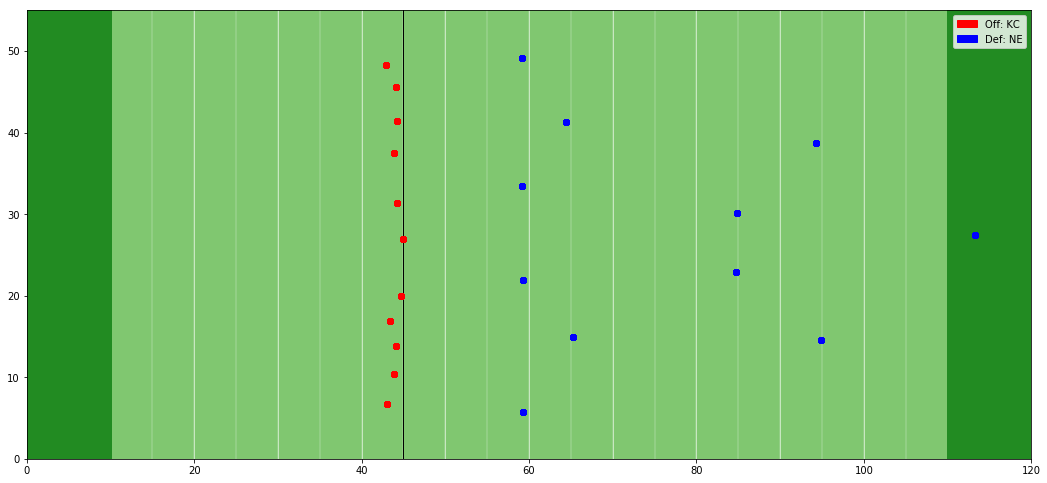


Game# [2017090700]
Play# [68]
O-Formation: [Singleback]
Scrimmage line at: [27.0] yd line.


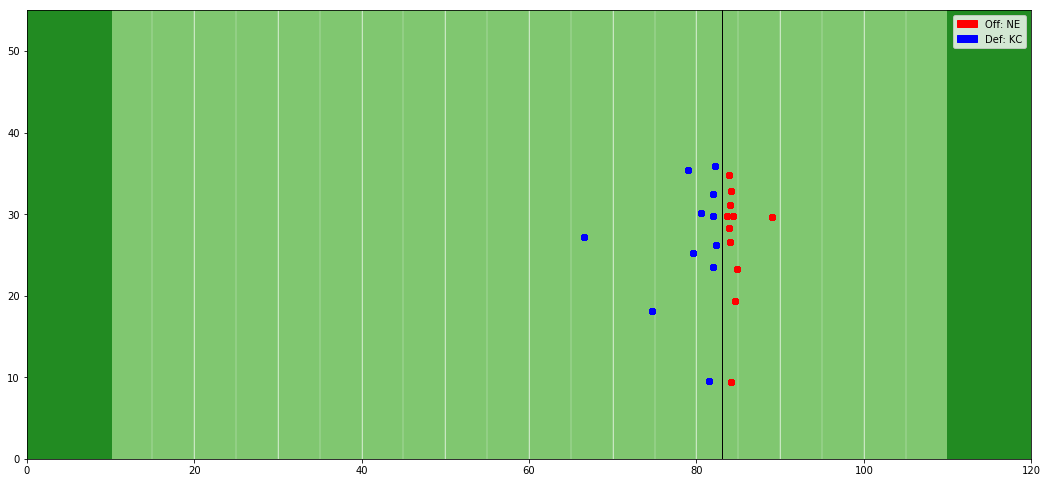


Game# [2017090700]
Play# [94]
O-Formation: [Singleback]
Scrimmage line at: [27.0] yd line.


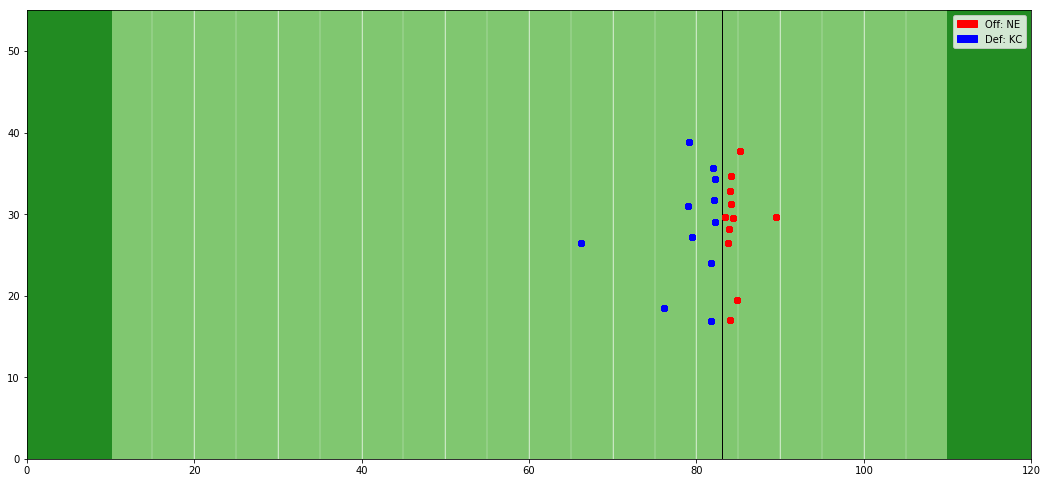


Game# [2017090700]
Play# [118]
O-Formation: [Shotgun]
Scrimmage line at: [35.0] yd line.


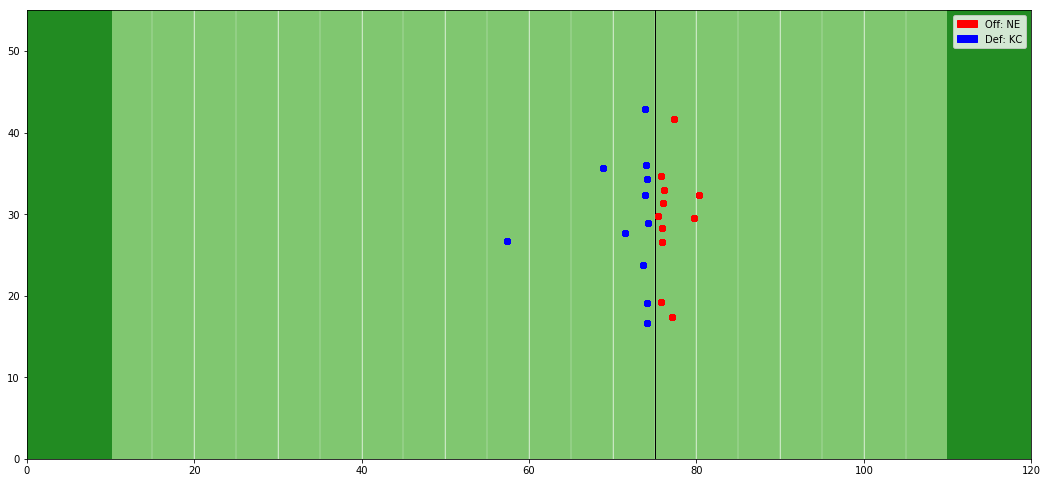


Game# [2017090700]
Play# [139]
O-Formation: [Shotgun]
Scrimmage line at: [43.0] yd line.


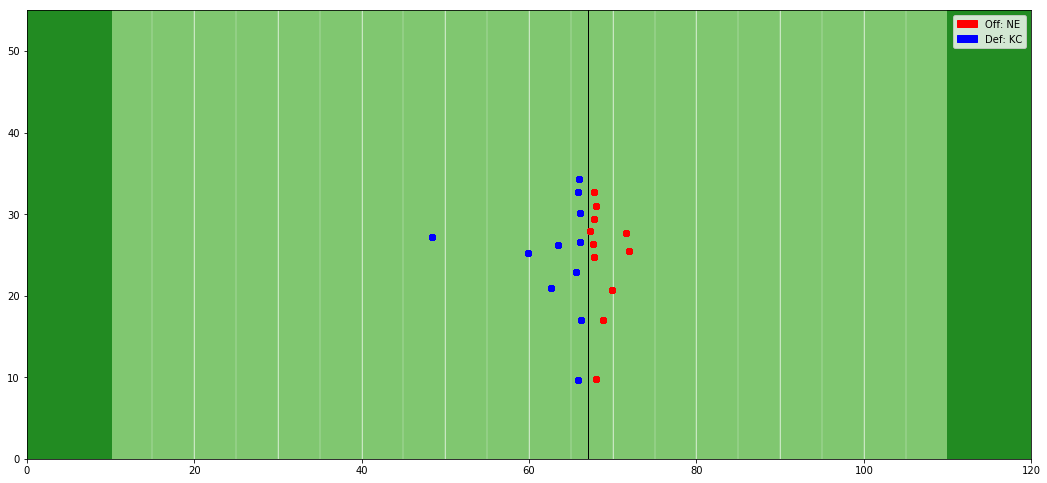


Game# [2017090700]
Play# [160]
O-Formation: [Empty]
Scrimmage line at: [46.0] yd line.


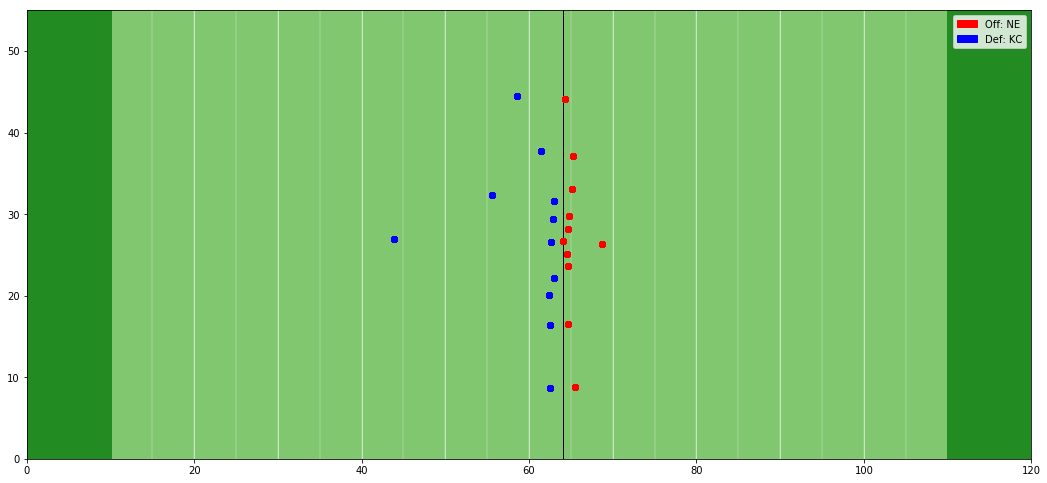


Game# [2017090700]
Play# [189]
O-Formation: [Singleback]
Scrimmage line at: [35.0] yd line.


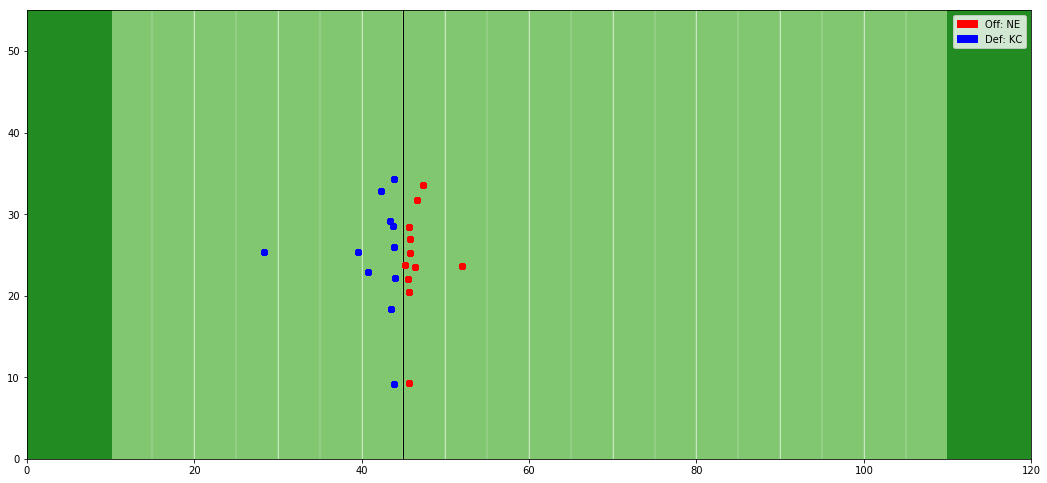


Game# [2017090700]
Play# [210]
O-Formation: [Empty]
Scrimmage line at: [30.0] yd line.


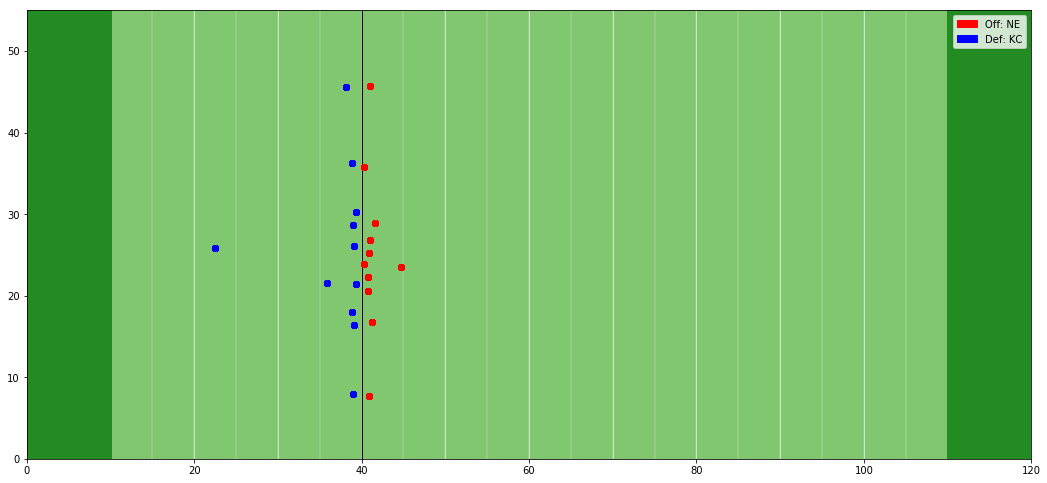


Game# [2017090700]
Play# [309]
O-Formation: [Jumbo]
Scrimmage line at: [2.0] yd line.


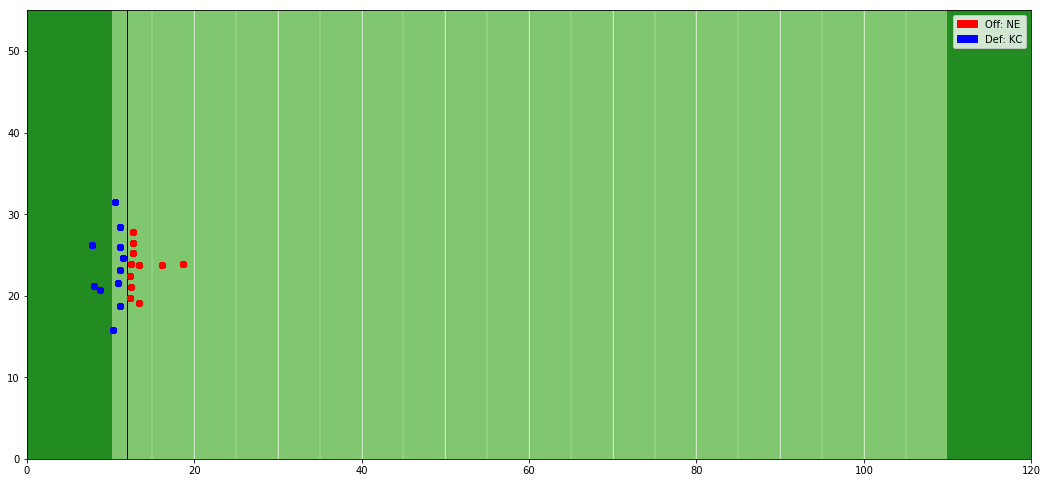


Game# [2017090700]
Play# [345]
O-Formation: [Jumbo]
Scrimmage line at: [2.0] yd line.


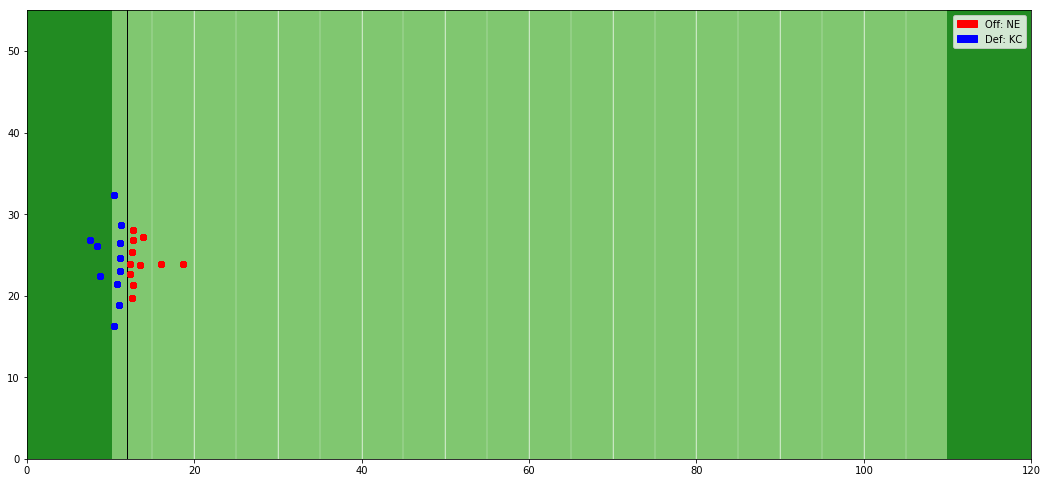


Game# [2017090700]
Play# [364]
O-Formation: [n/a]
Scrimmage line at: [15.0] yd line.


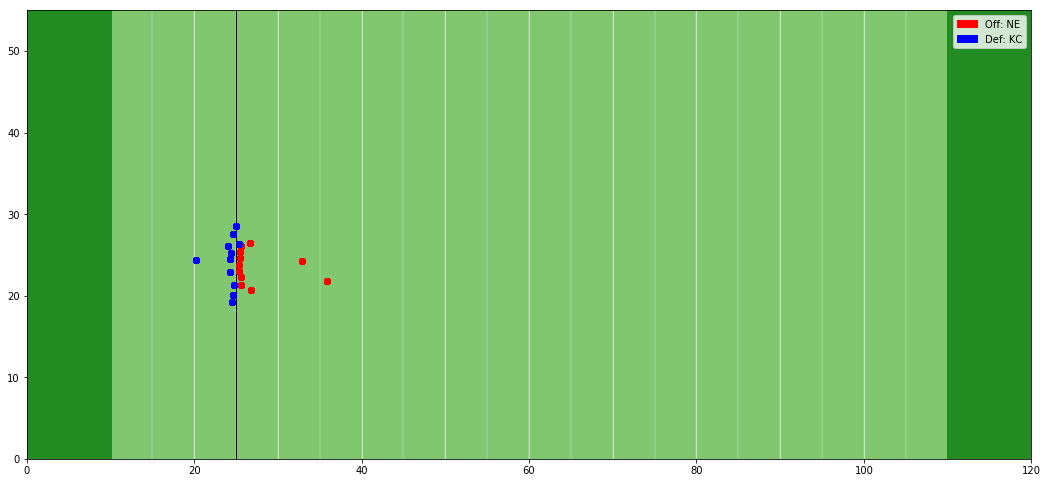


Game# [2017090700]
Play# [380]
O-Formation: [n/a]
Scrimmage line at: [35.0] yd line.


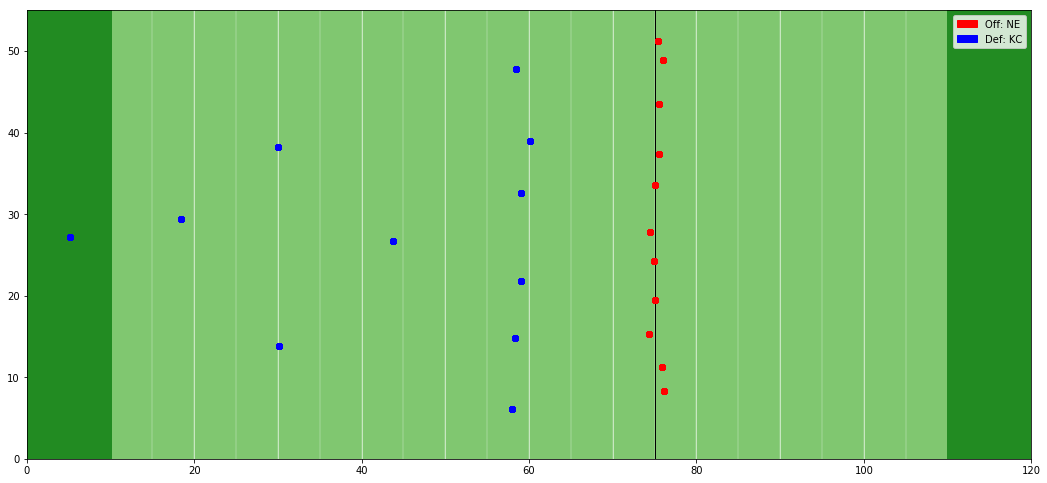


Game# [2017090700]
Play# [395]
O-Formation: [Shotgun]
Scrimmage line at: [25.0] yd line.


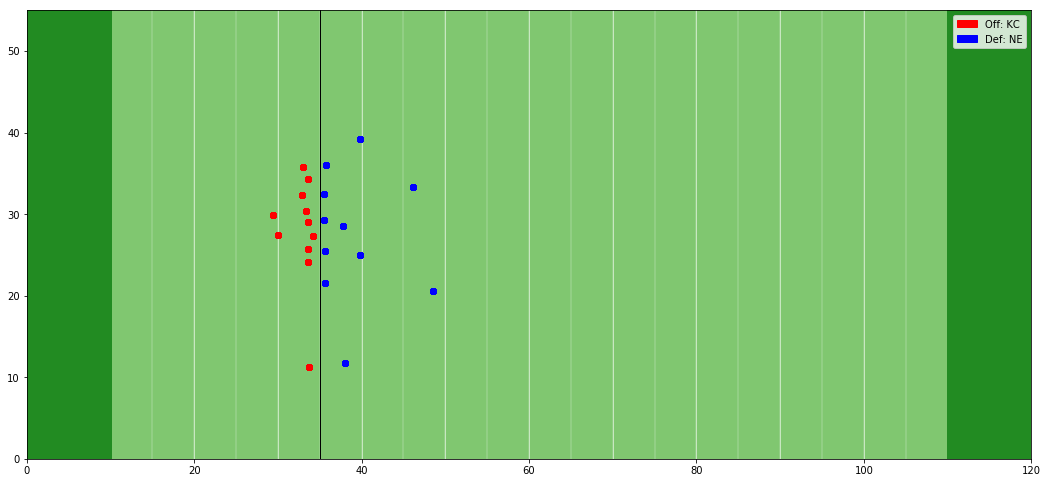


Game# [2017090700]
Play# [427]
O-Formation: [Shotgun]
Scrimmage line at: [32.0] yd line.


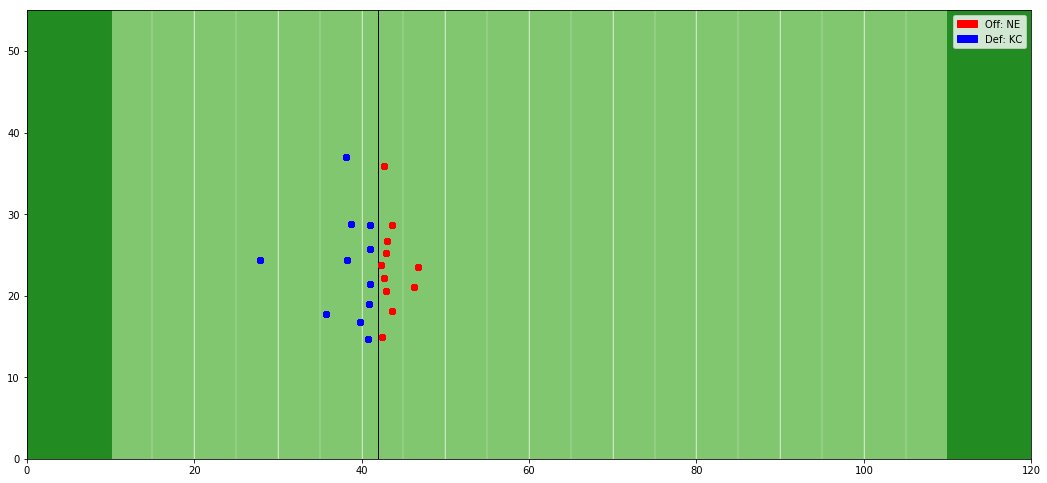


Game# [2017090700]
Play# [449]
O-Formation: [Empty]
Scrimmage line at: [32.0] yd line.


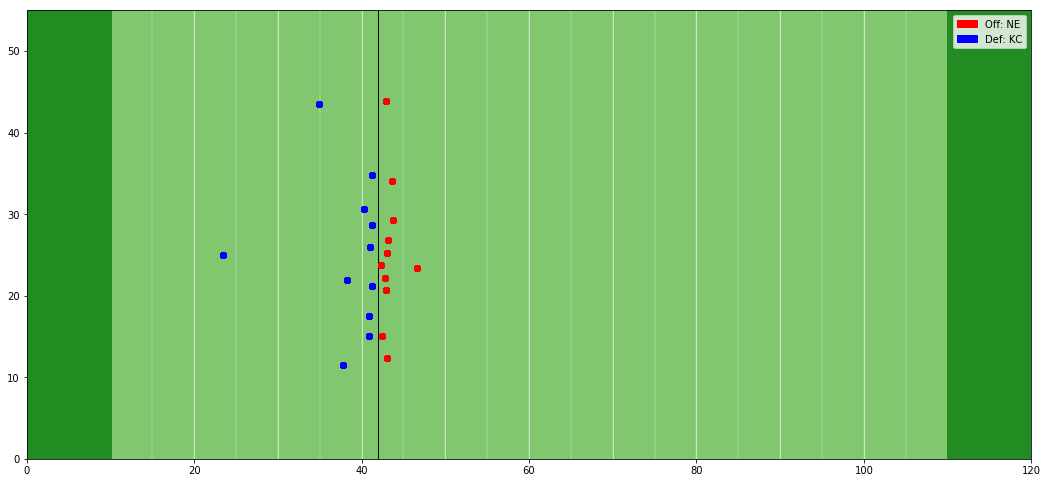


Game# [2017090700]
Play# [473]
O-Formation: [Shotgun]
Scrimmage line at: [29.0] yd line.


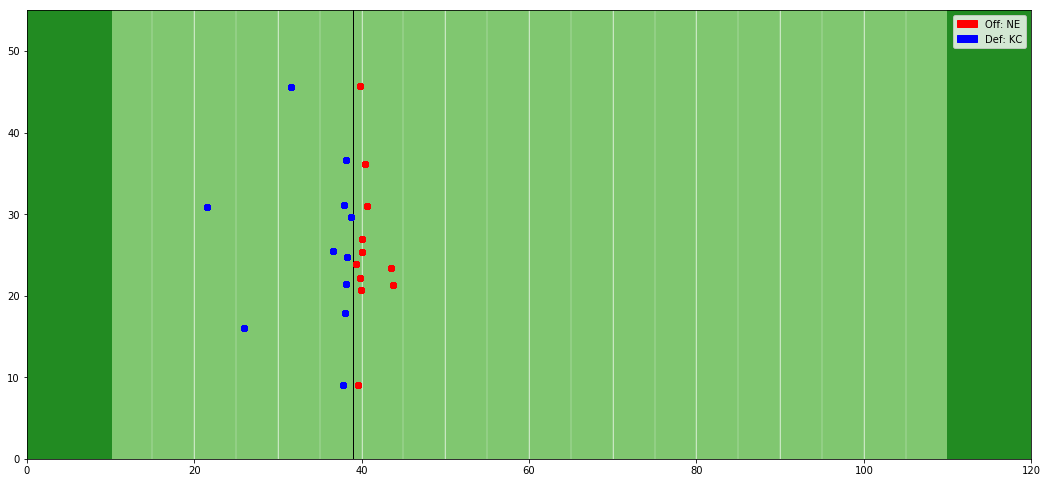


Game# [2017090700]
Play# [494]
O-Formation: [Empty]
Scrimmage line at: [19.0] yd line.


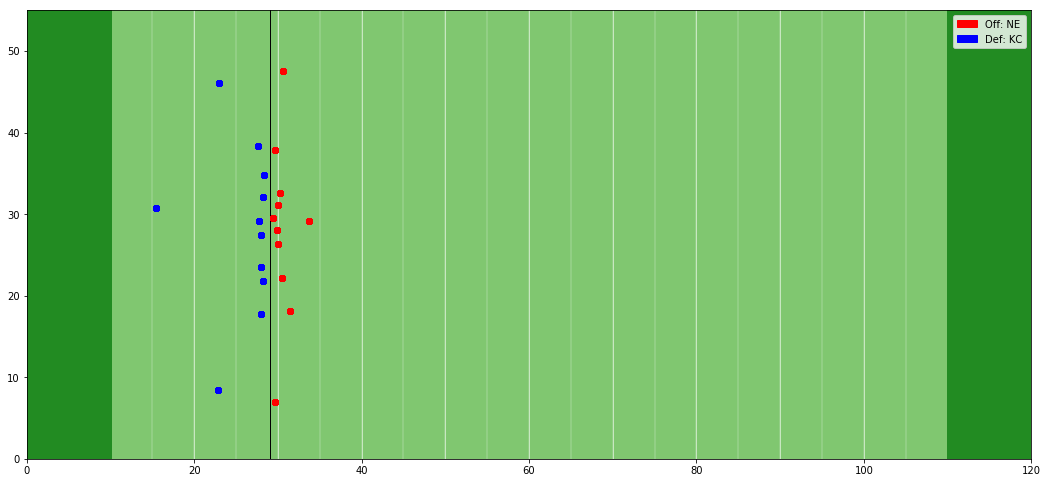


Game# [2017090700]
Play# [516]
O-Formation: [Singleback]
Scrimmage line at: [19.0] yd line.


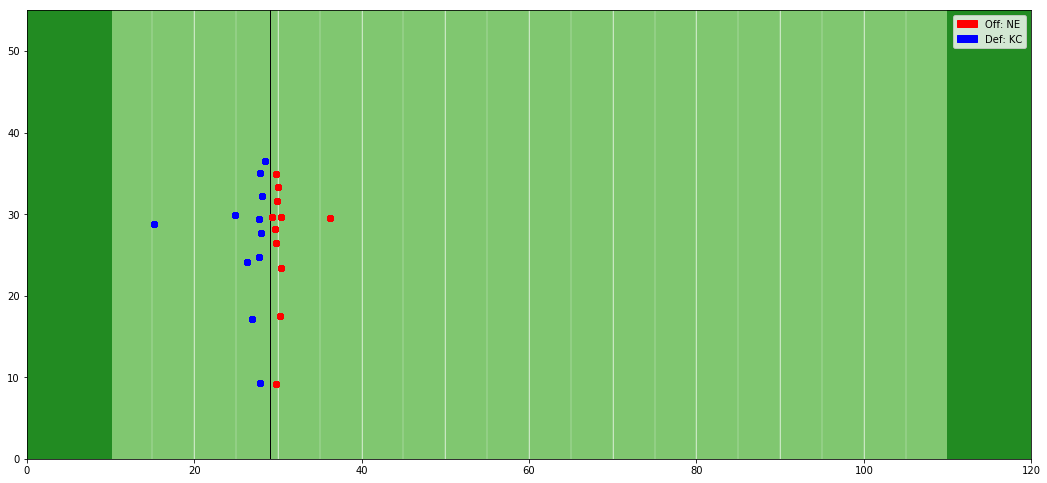


Game# [2017090700]
Play# [629]
O-Formation: [Shotgun]
Scrimmage line at: [15.0] yd line.


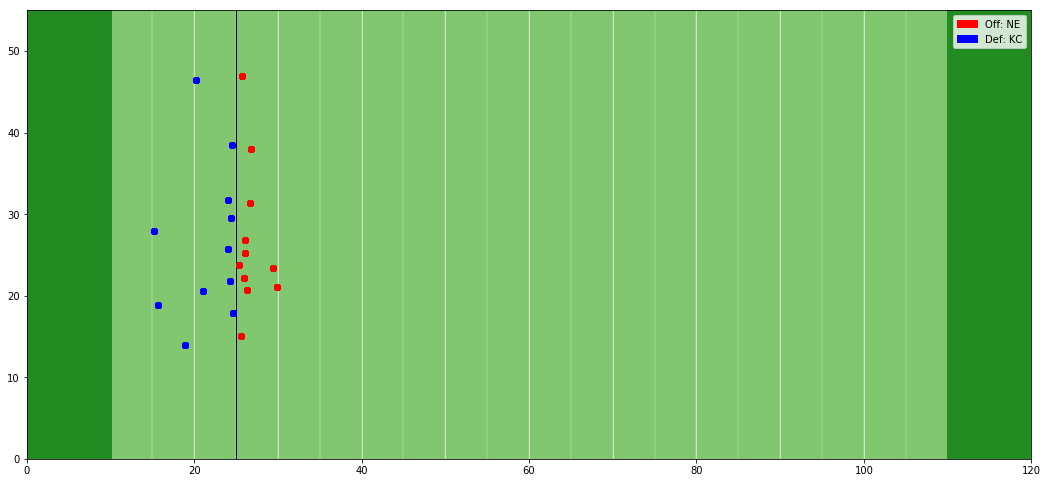


Game# [2017090700]
Play# [653]
O-Formation: [Singleback]
Scrimmage line at: [10.0] yd line.


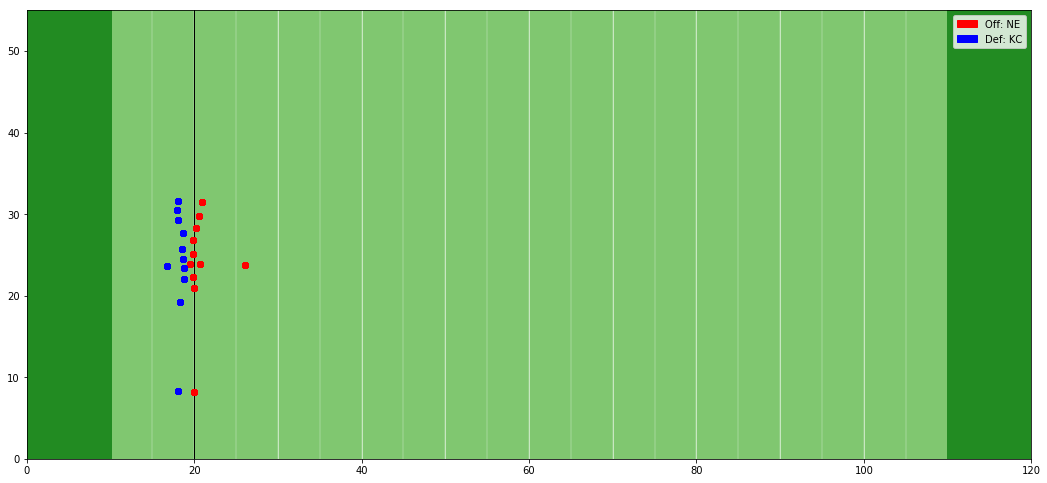

In [52]:
map_all(0)

In [42]:
# 2D array of [xi(relative),yi(relative)] positions
# changed to 1D
def clustering_xi_yi(game_num, play_num):
    df_offs = all_off_snaps.loc[all_off_snaps['gameId'] == game_num].loc[all_off_snaps['playId'] == play_num]

    try:
        x_mean = np.mean(df_offs['x'].values)
        x_median = statistics.median(df_offs['x'].values)
        y_mean = np.mean(df_offs['y'].values)
        y_median = statistics.median(df_offs['y'].values)
#         inp_list = []
#         inp_list2 = []
        x_list = []
        y_list = []
        if x_median > x_mean:
            for index,row in df_offs.iterrows():
                x_list.append(round(statistics.median(df_offs['x']) - row['x'], 2))
        elif x_mean > x_median:
            for index,row in df_offs.iterrows():
                x_list.append(round(row['x'] - statistics.median(df_offs['x']), 2))
        if y_median > y_mean:
            for index,row in df_offs.iterrows():
#                 y_list.append(round(maxrow['y'] - min(df_offs['y']), 2))
                y_list.append(round(statistics.median(df_offs['y']) - row['y'], 2))
        elif y_mean > y_median:
            for index,row in df_offs.iterrows():
                y_list.append(round(row['y'] - statistics.median(df_offs['y']), 2))

#         inp_list2 = np.reshape(inp_list, (-1, 2))
#         the_form = clean_plays.loc[clean_plays['gameId'] == game_num].loc[clean_plays['playId'] == play_num]['offenseFormation'].item()
#         output = the_form
#         if type(output) != str:
#             return None
        
        # note that inp_list is a list: [x1,y1,x2,y2...]
        if len(y_list) != 11 or len(x_list) != 11:
            return None
        return x_list, y_list
        # note that inp_list2 is an array: [[x1,y1],[x2,y2]...]
#         if len(inp_list2) != 11:
#             return None
#         return inp_list2, output
    except:
        pass

In [43]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

def make_cluster(number_of_games):
    plt.figure(figsize=(18,8.25))
    axes = plt.gca()
    axes.set_xlim([-10,10])
    axes.set_ylim([-50,50])

    x_arr = []
    y_arr = []
    arr = []
    for each_game in ret_list_of_games()[:number_of_games]:
        for each_play in ret_list_of_plays_of_game(each_game):
            try:
                x_arr.append(clustering_xi_yi(each_game, each_play)[0])
                y_arr.append(clustering_xi_yi(each_game, each_play)[1])
    #             arr2 = np.reshape(arr, (-1, 2))
    #             y_arr.append(clustering_xi_yi(each_game, each_play)[1])
    #             plt.scatter(clustering_xi_yi(each_game, each_play)[0], clustering_xi_yi(each_game, each_play)[1], c='red', zorder=4)
            except:
                pass
    x_arr = list(chain(*x_arr))
    y_arr = list(chain(*y_arr))

    points = []
    for each in range(0,len(x_arr)):
        points.append([x_arr[each], y_arr[each]])

    points = np.asarray(points)
    plt.scatter(points[:,0], points[:,1], cmap='viridis')
    # plt.xlim(-20,40)
    # plt.ylim(-50,50)

    # create kmeans object
    kmeans = KMeans(n_clusters=11)
    # fit kmeans object to data
    kmeans.fit(points)
    # print location of clusters learned by kmeans object
    print('Cluster centers:')
    print(kmeans.cluster_centers_)
    # save new clusters for chart
    y_km = kmeans.fit_predict(points)

    plt.scatter(points[y_km==0,0], points[y_km==0,1], c='red')
    plt.scatter(points[y_km==1,0], points[y_km==1,1], c='black')
    plt.scatter(points[y_km==2,0], points[y_km==2,1], c='blue')
    plt.scatter(points[y_km==3,0], points[y_km==3,1], c='cyan')
    plt.scatter(points[y_km==4,0], points[y_km==4,1], c='purple')
    plt.scatter(points[y_km==5,0], points[y_km==5,1], c='magenta')
    plt.scatter(points[y_km==6,0], points[y_km==6,1], c='orange')
    plt.scatter(points[y_km==7,0], points[y_km==7,1], c='pink')
    plt.scatter(points[y_km==8,0], points[y_km==8,1], c='green')
    plt.scatter(points[y_km==9,0], points[y_km==9,1], c='gray')
    plt.scatter(points[y_km==10,0], points[y_km==10,1], c='gold')

Cluster centers:
[[ -0.02208858   2.33464039]
 [  0.12044046  -8.20327896]
 [  0.03354309  19.60058824]
 [  0.33403631   9.4473324 ]
 [  0.08307403  -3.71270386]
 [  3.53395404  -0.94438193]
 [ -0.11868132 -14.52009419]
 [ -0.31043033  -0.67534153]
 [  0.32108108  12.83898649]
 [  5.52095578   0.5881883 ]
 [  0.3382854    5.39131637]]


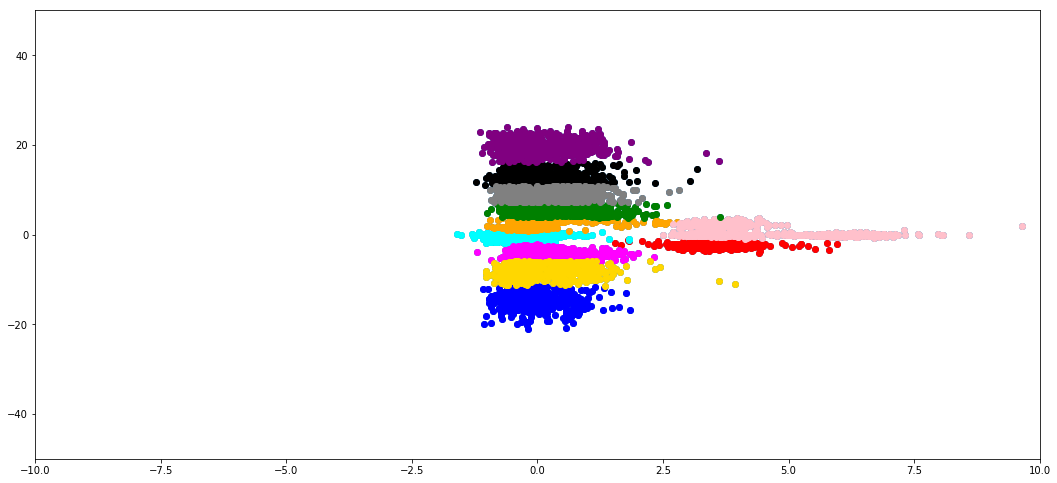

In [44]:
# 5 game cluster
# --- 8.12437796592712 seconds ---
make_cluster(10)

Cluster centers:
[[ -0.03061273   2.3371534 ]
 [  0.04076849  19.50271863]
 [  0.03132811  -8.09472387]
 [  0.25394545   9.21940737]
 [  0.06804007  -3.7403623 ]
 [  4.38106048   0.32462559]
 [ -0.14519686 -14.59278278]
 [ -0.30721277  -0.68213795]
 [  0.28739814  12.67858157]
 [  0.30716557   5.34353219]
 [  3.62143914  -2.46002325]]


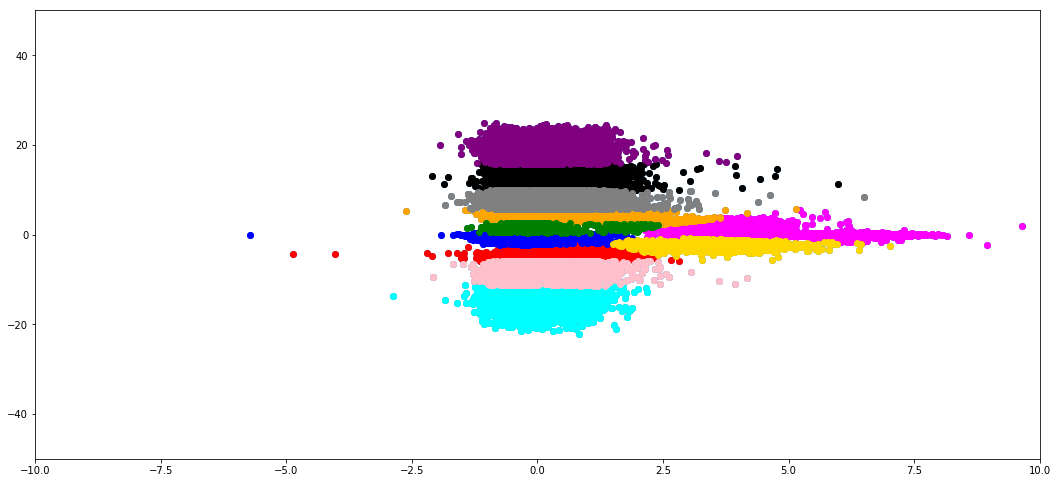

In [45]:
# 91 game cluster
# --- 76.73480582237244 seconds ---
make_cluster(len(ret_list_of_games()))

In [46]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def make_hierarchy(number_of_games):
    x_arr = []
    y_arr = []
    arr = []
    for each_game in ret_list_of_games()[:number_of_games]:
        for each_play in ret_list_of_plays_of_game(each_game):
            try:
                x_arr.append(clustering_xi_yi(each_game, each_play)[0])
                y_arr.append(clustering_xi_yi(each_game, each_play)[1])
    #             arr2 = np.reshape(arr, (-1, 2))
    #             y_arr.append(clustering_xi_yi(each_game, each_play)[1])
    #             plt.scatter(clustering_xi_yi(each_game, each_play)[0], clustering_xi_yi(each_game, each_play)[1], c='red', zorder=4)
            except:
                pass
    x_arr = list(chain(*x_arr))
    y_arr = list(chain(*y_arr))

    points = []
    for each in range(0,len(x_arr)):
        points.append([x_arr[each], y_arr[each]])

    points = np.asarray(points)
    
    plt.figure(2)
    plt.figure(figsize=(18,8.25))
    axes = plt.gca()
    axes.set_xlim([-10,10])
    axes.set_ylim([-50,50])
    # create dendrogram
    dendrogram = sch.dendrogram(sch.linkage(points, method='ward'))
    # create clusters
    hc = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(points)
    
    plt.figure(3)
    plt.figure(figsize=(18,8.25))
    axes = plt.gca()
    axes.set_xlim([-10,10])
    axes.set_ylim([-50,50])
    
    plt.scatter(points[y_hc==0,0], points[y_hc==0,1], c='red')
    plt.scatter(points[y_hc==1,0], points[y_hc==1,1], c='black')
    plt.scatter(points[y_hc==2,0], points[y_hc==2,1], c='blue')
    plt.scatter(points[y_hc==3,0], points[y_hc==3,1], c='cyan')
    plt.scatter(points[y_hc==4,0], points[y_hc==4,1], c='purple')
    plt.scatter(points[y_hc==5,0], points[y_hc==5,1], c='magenta')
    plt.scatter(points[y_hc==6,0], points[y_hc==6,1], c='orange')
    plt.scatter(points[y_hc==7,0], points[y_hc==7,1], c='pink')
    plt.scatter(points[y_hc==8,0], points[y_hc==8,1], c='green')
    plt.scatter(points[y_hc==9,0], points[y_hc==9,1], c='yellow')
    plt.scatter(points[y_hc==10,0], points[y_hc==10,1], c='gold')

34.0770947933197

<Figure size 432x288 with 0 Axes>

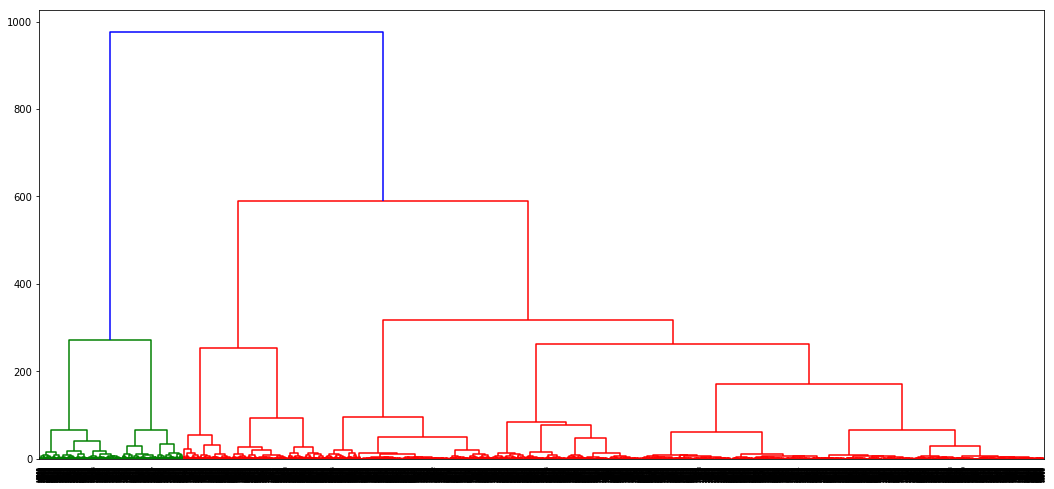

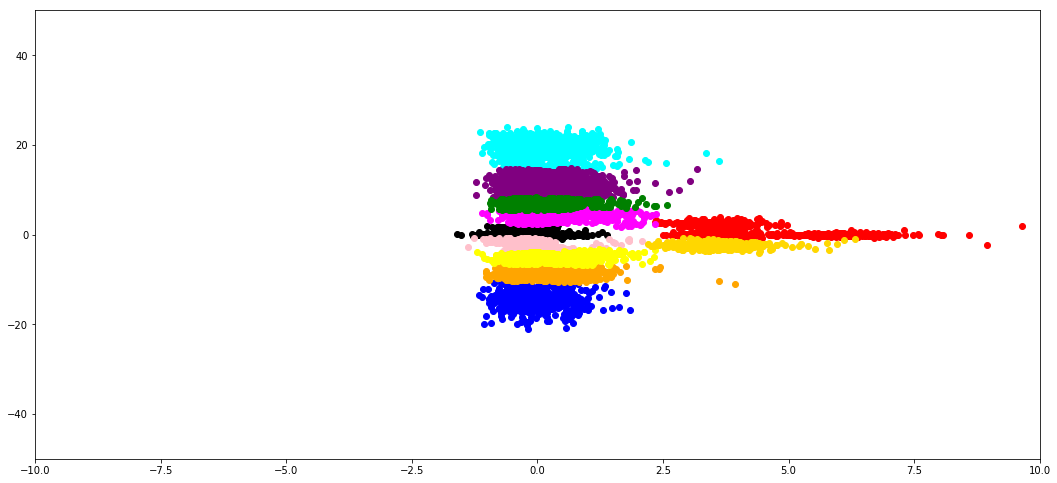

In [49]:
# CAUTION!! VERY COMPUTATIONALLY EXPENSIVE AND CRASHED MY COMPUTER WHEN I TRIED TO MAKE IT RUN OVER 91 GAMES.
# Honestly this was a little unneeded so no need to rerun this cell.
make_hierarchy(12)